In [ ]:
!pip install ultralytics roboflow supervision==0.19.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.6 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76


In [ ]:
import numpy as np
import numpy.typing as npt
import supervision as sv
import os
import cv2
from ultralytics import YOLO
from PIL import Image

from dataclasses import replace
from typing import Iterable, Optional, Tuple

from supervision import Detections
from supervision.detection.utils import clip_boxes, polygon_to_mask
from supervision.draw.color import Color
from supervision.draw.utils import draw_polygon, draw_text
from supervision.geometry.core import Position
from supervision.geometry.utils import get_polygon_center
from supervision.utils.internal import deprecated_parameter

In [ ]:
%cd /content/drive/MyDrive
HOME = os.getcwd()
MODEL = f"{HOME}/runs/detect/train4/weights/best.pt"

# initialize the model
model = YOLO(MODEL)
model.fuse()

/content/drive/MyDrive
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs


In [ ]:
def detect(frame: np.ndarray) -> sv.Detections:
    result = model.predict(frame, imgsz=1280, conf=0.5, verbose=False)[0]
    return sv.Detections.from_ultralytics(result)

In [ ]:
def point_in_rect(px: int, py: int, rx1: int, ry1: int, rx2: int, ry2: int) -> bool:
    """
    Check if a point (px, py) is inside a rectangle defined by its top-left (rx1, ry1)
    and bottom-right (rx2, ry2) coordinates.

    Parameters:
    px (float): x-coordinate of the point.
    py (float): y-coordinate of the point.
    rx1 (float): x-coordinate of the rectangle's top-left corner.
    ry1 (float): y-coordinate of the rectangle's top-left corner.
    rx2 (float): x-coordinate of the rectangle's bottom-right corner.
    ry2 (float): y-coordinate of the rectangle's bottom-right corner.

    Returns:
    bool: True if the point is inside the rectangle, False otherwise.
    """
    return rx1 <= px <= rx2 and ry1 <= py <= ry2

def rectangles_intersect(r1_p1: tuple[int, int], r1_p2: tuple[int, int],
                         r2_p1: tuple[int, int], r2_p2: tuple[int, int]) -> bool:
    """
    Check if two rectangles intersect. Each rectangle is defined by two points:
    the top-left and the bottom-right corners.

    Parameters:
    r1_p1 (tuple[float, float]): Top-left corner of the first rectangle (x1, y1).
    r1_p2 (tuple[float, float]): Bottom-right corner of the first rectangle (x2, y2).
    r2_p1 (tuple[float, float]): Top-left corner of the second rectangle (x1, y1).
    r2_p2 (tuple[float, float]): Bottom-right corner of the second rectangle (x2, y2).

    Returns:
    bool: True if the rectangles intersect, False otherwise.
    """
    # Unpack rectangle points
    r1_x1, r1_y1 = r1_p1
    r1_x2, r1_y2 = r1_p2
    r2_x1, r2_y1 = r2_p1
    r2_x2, r2_y2 = r2_p2

    # Define the vertices for both rectangles
    r1_vertices = [(r1_x1, r1_y1), (r1_x2, r1_y1), (r1_x2, r1_y2), (r1_x1, r1_y2)]
    r2_vertices = [(r2_x1, r2_y1), (r2_x2, r2_y1), (r2_x2, r2_y2), (r2_x1, r2_y2)]

    # Check if any vertex of rectangle 1 is inside rectangle 2 or vice versa
    return any(point_in_rect(px, py, r2_x1, r2_y1, r2_x2, r2_y2) for px, py in r1_vertices) or \
           any(point_in_rect(px, py, r1_x1, r1_y1, r1_x2, r1_y2) for px, py in r2_vertices)



In [ ]:
class PolygonZone:
    """
    A class for defining a polygon-shaped zone within a frame for detecting objects.

    Attributes:
        polygon (np.ndarray): A polygon represented by a numpy array of shape
            `(N, 2)`, containing the `x`, `y` coordinates of the points.
        frame_resolution_wh (Tuple[int, int]): The frame resolution (width, height)
        triggering_anchors (Iterable[sv.Position]): A list of positions specifying
            which anchors of the detections bounding box to consider when deciding on
            whether the detection fits within the PolygonZone
            (default: (sv.Position.BOTTOM_CENTER,)).
        current_count (int): The curren|t count of detected objects within the zone
        mask (np.ndarray): The 2D bool mask for the polygon zone
    """

    @deprecated_parameter(
        old_parameter="triggering_position",
        new_parameter="triggering_anchors",
        map_function=lambda x: [x],
        warning_message="`{old_parameter}` in `{function_name}` is deprecated and will "
        "be remove in `supervision-0.23.0`. Use '{new_parameter}' "
        "instead.",
    )
    def __init__(
        self,
        polygon: npt.NDArray[np.int64],
        frame_resolution_wh: Tuple[int, int],
        triggering_anchors: Iterable[Position] = (Position.BOTTOM_CENTER,),

    ):
        self.polygon = polygon.astype(int)
        self.frame_resolution_wh = frame_resolution_wh
        self.triggering_anchors = triggering_anchors

        self.current_count = 0

        width, height = frame_resolution_wh
        self.mask = polygon_to_mask(
            polygon=polygon, resolution_wh=(width + 1, height + 1)
        )

    def trigger(self, detections: Detections, class_name):
        """
        Determines if the spicific objects are within the polygon zone.

        Return:
        False, if none of the ojects of the specified class are within the polygon zone.
        True, if at least one of the ojects of the specified class are within the polygon zone.
        """

        triggers = []

        for obj in iter(detections):

            if obj[5].get('class_name') == class_name:
                obj_x1, obj_y1, obj_x2, obj_y2 = obj[0]
                obj_p1 = (obj_x1, obj_y1)
                obj_p2 = (obj_x2, obj_y2)

                zone_p1 = self.polygon[0]
                zone_p2 = self.polygon[2]

                triggers.append(rectangles_intersect(obj_p1, obj_p2, zone_p1, zone_p2))

        return any(triggers)


class PolygonZoneAnnotator:
    """
    A class for annotating a polygon-shaped zone within a
        frame with a count of detected objects.

    Attributes:
        zone (PolygonZone): The polygon zone to be annotated
        color (Color): The color to draw the polygon lines
        thickness (int): The thickness of the polygon lines, default is 2
        text_color (Color): The color of the text on the polygon, default is black
        text_scale (float): The scale of the text on the polygon, default is 0.5
        text_thickness (int): The thickness of the text on the polygon, default is 1
        text_padding (int): The padding around the text on the polygon, default is 10
        font (int): The font type for the text on the polygon,
            default is cv2.FONT_HERSHEY_SIMPLEX
        center (Tuple[int, int]): The center of the polygon for text placement
        display_in_zone_count (bool): Show the label of the zone or not. Default is True
    """

    def __init__(
        self,
        zone: PolygonZone,
        color: Color,
        thickness: int = 2,
        text_color: Color = Color.BLACK,
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
        display_in_zone_count: bool = True,
    ):
        self.zone = zone
        self.color = color
        self.thickness = thickness
        self.text_color = text_color
        self.text_scale = text_scale
        self.text_thickness = text_thickness
        self.text_padding = text_padding
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        self.center = get_polygon_center(polygon=zone.polygon)
        self.display_in_zone_count = display_in_zone_count

    def annotate(self, scene: np.ndarray, label: Optional[str] = None) -> np.ndarray:
        """
        Annotates the polygon zone within a frame with a count of detected objects.

        Parameters:
            scene (np.ndarray): The image on which the polygon zone will be annotated
            label (Optional[str]): An optional label for the count of detected objects
                within the polygon zone (default: None)

        Returns:
            np.ndarray: The image with the polygon zone and count of detected objects
        """
        annotated_frame = draw_polygon(
            scene=scene,
            polygon=self.zone.polygon,
            color=self.color,
            thickness=self.thickness,
        )

        if self.display_in_zone_count:
            annotated_frame = draw_text(
                scene=annotated_frame,
                text=str(self.zone.current_count) if label is None else label,
                text_anchor=self.center,
                background_color=self.color,
                text_color=self.text_color,
                text_scale=self.text_scale,
                text_thickness=self.text_thickness,
                text_padding=self.text_padding,
                text_font=self.font,
            )

        return annotated_frame

In [ ]:
# define annotation classes
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.4)

def setup_zone_above(detections, frame_wh):
    zones = []
    count_zone = 0
    for i in range(len(detections)):
        obj = detections[i]

        # choosing only baskets with confidence score >= 0.5
        if (obj.data.get('class_name')[0] == 'basket') & (obj.confidence[0] >= 0.5):
            count_zone += 1

            obj_xyxy = obj.xyxy[0]

            # get coordinates of 4 points of bounding box
            obj_p1 = np.array([obj_xyxy[0], obj_xyxy[1]])
            obj_p2 = np.array([obj_xyxy[0], obj_xyxy[3]])
            obj_p3 = np.array([obj_xyxy[2], obj_xyxy[3]])
            obj_p4 = np.array([obj_xyxy[2], obj_xyxy[1]])

            # get height and width of bounding box
            obj_height = obj_xyxy[3] - obj_xyxy[1]
            obj_width = obj_xyxy[2] - obj_xyxy[0]

            # polygon construction strategy
            # 1) polygon width will be width of "basket" bounding box increased on 10% (5% from left and right sides)
            # 2) polygon height will be height of "basket" bounding box
            # 3) obj_p1 and obj_p4 will become the zone_p2 and zone_p3 respectively
            # 4) polygon will be exactly above the basket bounding box

            zone_p1 = [obj_p1[0] - 0.05 * obj_width, obj_p1[1] - obj_height]
            zone_p2 = [obj_p1[0] - 0.05 * obj_width, obj_p1[1]]
            zone_p3 = [obj_p4[0] + 0.05 * obj_width, obj_p4[1]]
            zone_p4 = [obj_p4[0] + 0.05 * obj_width, obj_p4[1] - obj_height]

            # round coordinates of each point of zone
            zone_p1 = list(map(round, zone_p1))
            zone_p2 = list(map(round, zone_p2))
            zone_p3 = list(map(round, zone_p3))
            zone_p4 = list(map(round, zone_p4))

            zone_coordinates = np.array([zone_p1, zone_p2, zone_p3, zone_p4])
            zone_name = f"Zone {count_zone}"

            zone = {
                'name': zone_name,
                'polygon': zone_coordinates,
                'count': 0
            }

            zone['PolygonZone'] = PolygonZone(
                polygon=zone['polygon'],
                frame_resolution_wh=frame_wh
            )

            zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
                zone=zone['PolygonZone'],
                color=sv.Color.WHITE,
                thickness=2,
                text_thickness=1,
                text_scale=0.3,
                text_padding=3
            )

            zones.append(zone)

    return zones


def setup_zone_below(detections, frame_wh):
    zones = []
    count_zone = 0
    for i in range(len(detections)):
        obj = detections[i]


        # choosing only baskets with confidence score >= 0.5
        if (obj.data.get('class_name')[0] == 'basket') & (obj.confidence[0] >= 0.5):
            count_zone += 1

            obj_xyxy = obj.xyxy[0]

            # get coordinates of 4 points of bounding box
            obj_p1 = np.array([obj_xyxy[0], obj_xyxy[1]])
            obj_p2 = np.array([obj_xyxy[0], obj_xyxy[3]])
            obj_p3 = np.array([obj_xyxy[2], obj_xyxy[3]])
            obj_p4 = np.array([obj_xyxy[2], obj_xyxy[1]])

            # get height and width of bounding box
            obj_height = obj_xyxy[3] - obj_xyxy[1]
            obj_width = obj_xyxy[2] - obj_xyxy[0]

            # polygon construction strategy
            # 1) polygon width will be width of "basket" bounding box decreased on 40% (20% from left and right sides)
            # 2) polygon height will be height of "basket" bounding box
            # 3) polygon will be lower the basket bounding box on 0.5 height of it

            zone_p1 = [obj_p1[0] + 0.2 * obj_width, obj_p1[1] + 0.5 * obj_height]
            zone_p2 = [obj_p1[0] + 0.2 * obj_width, obj_p1[1] + 1.5 * obj_height]
            zone_p3 = [obj_p4[0] - 0.2 * obj_width, obj_p4[1] + 1.5 * obj_height]
            zone_p4 = [obj_p4[0] - 0.2 * obj_width, obj_p4[1] + 0.5 * obj_height]

            # round coordinates of each point of zone
            zone_p1 = list(map(round, zone_p1))
            zone_p2 = list(map(round, zone_p2))
            zone_p3 = list(map(round, zone_p3))
            zone_p4 = list(map(round, zone_p4))

            zone_coordinates = np.array([zone_p1, zone_p2, zone_p3, zone_p4])
            zone_name = f"Zone {count_zone}"

            zone = {
                'name': zone_name,
                'polygon': zone_coordinates,
                'count': 0
            }

            zone['PolygonZone'] = PolygonZone(
                polygon=zone['polygon'],
                frame_resolution_wh=frame_wh
            )

            zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
                zone=zone['PolygonZone'],
                color=sv.Color.WHITE,
                thickness=2,
                text_thickness=1,
                text_scale=0.3,
                text_padding=3
            )

            zones.append(zone)

    return zones


def setup_zone_general(detections, frame_wh, zones_above, zones_below):
    general_zones = []

    for count_zone in range(len(zones_above)):

        y1 = zones_above[count_zone]['polygon'][0][1] # the upper y coordinate
        y2 = zones_below[count_zone]['polygon'][1][1] # the lower y coordinate
        width = zones_above[count_zone]['polygon'][3][0] - zones_above[count_zone]['polygon'][0][0]
        x1 = round(zones_above[count_zone]['polygon'][0][0] - 0.5 * width)
        x2 = round(zones_above[count_zone]['polygon'][3][0] + 0.5 * width)

        general_zone_p1 = [x1, y1]
        general_zone_p2 = [x1, y2]
        general_zone_p3 = [x2, y2]
        general_zone_p4 = [x2, y1]

        general_zone_coord = np.array([general_zone_p1, general_zone_p2, general_zone_p3, general_zone_p4])

        general_zone_name = f"Zone {count_zone + 1}"

        general_zone = {
            'name': general_zone_name,
            'polygon': general_zone_coord,
            'count': 0
        }

        general_zone['PolygonZone'] = PolygonZone(
            polygon=general_zone['polygon'],
            frame_resolution_wh=frame_wh
        )

        general_zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
            zone=general_zone['PolygonZone'],
            color=sv.Color.WHITE,
            thickness=2,
            text_thickness=1,
            text_scale=0.3,
            text_padding=3
        )

        general_zones.append(general_zone)

    return general_zones

def choosing_largest_zone(zones):
    max_square = 0
    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        square = (x2 - x1) * (y2 - y1)

        if square > max_square:
            max_square = square

    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        if (x2 - x1) * (y2 - y1) == max_square:
            return zone


**Model inference**

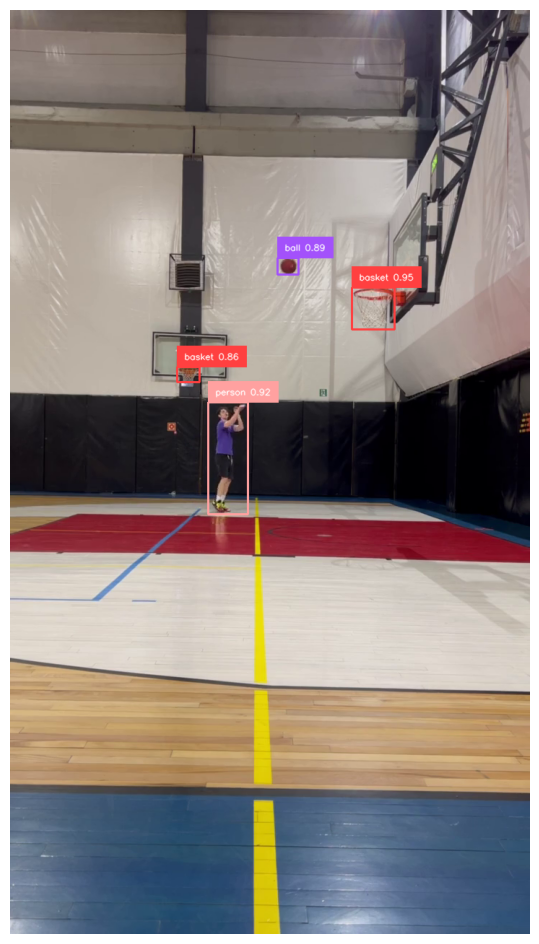

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(300):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

sv.plot_image(annotated_frame)

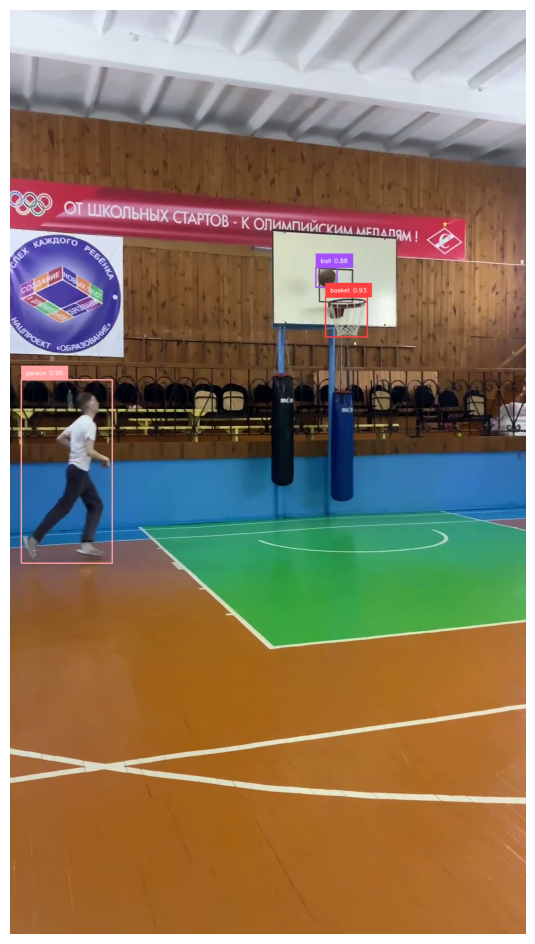

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/2.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(115):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

sv.plot_image(annotated_frame)

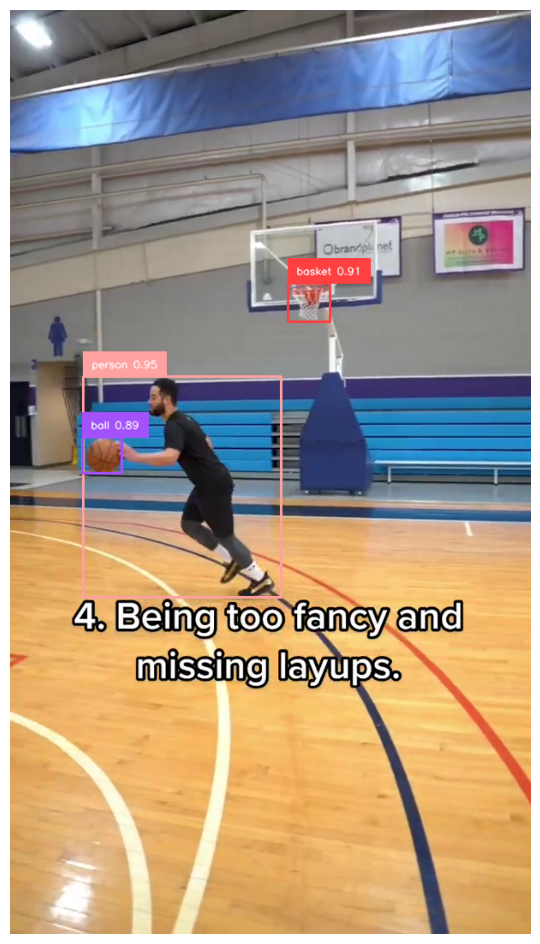

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/videoplayback.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(618):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

sv.plot_image(annotated_frame)

**Model inference with zones**

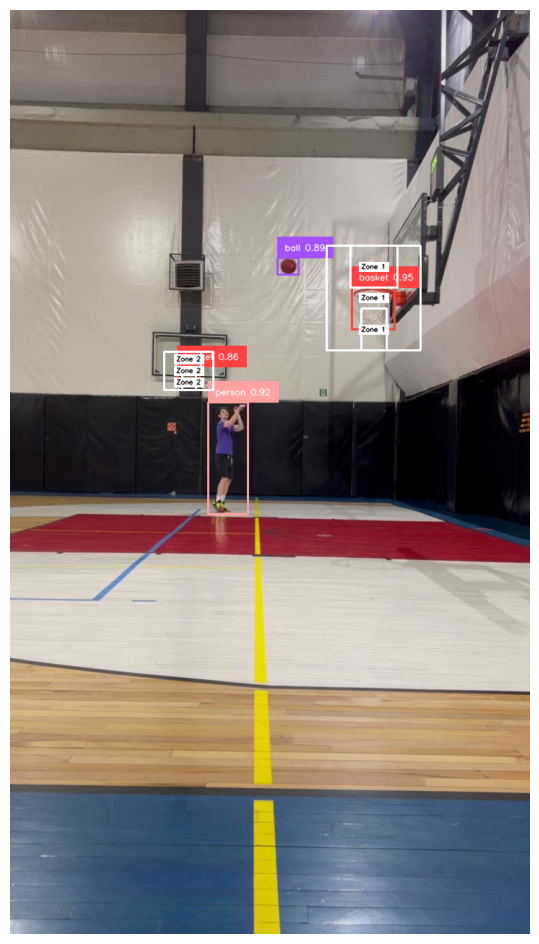

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(300):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

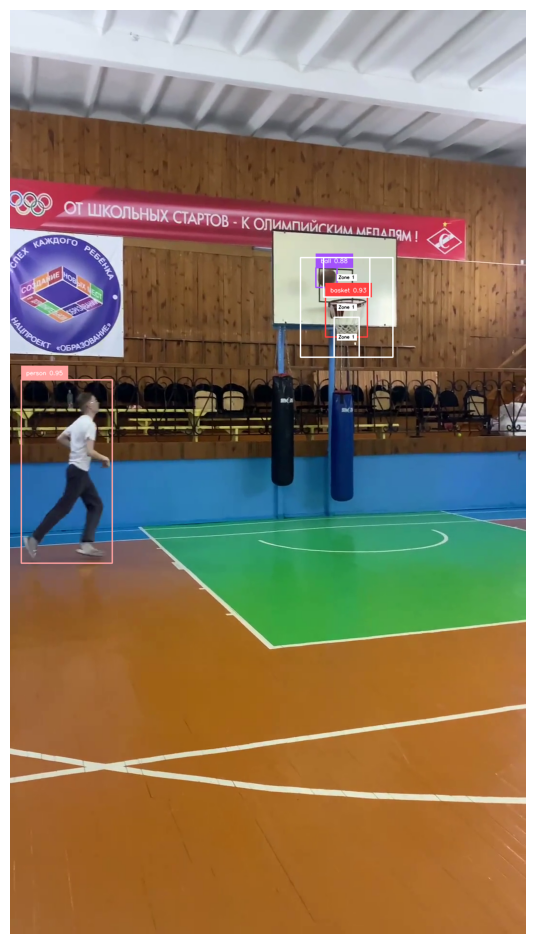

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/2.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(115):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

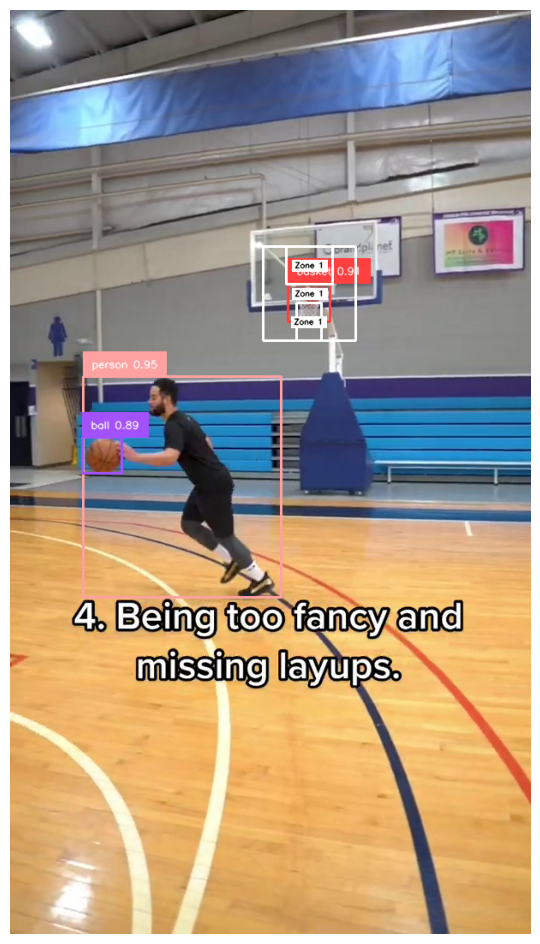

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/videoplayback.mp4"
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = 0
for i in range(618):
    frame = next(frames_generator) # get the 1st frame
detections = detect(frame)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)
zones_general = setup_zone_general(detections, video_info.resolution_wh, zones_above, zones_below)

# labels for bounding boxes
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_general:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

In [ ]:
def choosing_largest_zone(zones):
    max_square = 0
    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        square = (x2 - x1) * (y2 - y1)

        if square > max_square:
            max_square = square

    for zone in zones:
        zone_coord = zone.get('polygon')
        x1 = zone_coord[0][0]
        x2 = zone_coord[3][0]
        y1 = zone_coord[0][1]
        y2 = zone_coord[0][1]

        if (x2 - x1) * (y2 - y1) == max_square:
            return zone


In [ ]:
def callback(frame: np.ndarray, frame_wh, frame_num: int, zone_above, zone_below, zone_general, zone_above_triggered, zone_general_triggered, score, throws) -> np.ndarray:

    detections = detect(frame)


    # define zones by first frame
    if frame_num == 0:
        zones_above = setup_zone_above(detections, frame_wh)
        zones_below = setup_zone_below(detections, frame_wh)
        zones_general = setup_zone_general(detections, frame_wh, zones_above, zones_below)

        # choose only one zone above, below and general by greatest size
        zone_above = choosing_largest_zone(zones_above)
        zone_below = choosing_largest_zone(zones_below)
        zone_general = choosing_largest_zone(zones_general)


    # bounding boxes labels
    labels = [
        f"{model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id
        in zip(detections.confidence, detections.class_id)
    ]

    # draw bounding boxes with labels
    annotated_frame = frame.copy()
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # get person and ball bounding boxes coordinates of points of main diagonal
    person_p1 = person_p2 = (0, 0)
    ball_p1 = ball_p2 = (0, 0)

    # intersection between player and ball
    for obj in iter(detections):
        if obj[5].get('class_name') == 'person':
            person_x1, person_y1, person_x2, person_y2 = obj[0]
            person_p1 = (person_x1, person_y1)
            person_p2 = (person_x2, person_y2)

        if obj[5].get('class_name') == 'ball':
            ball_x1, ball_y1, ball_x2, ball_y2 = obj[0]
            ball_p1 = (ball_x1, ball_y1)
            ball_p2 = (ball_x2, ball_y2)

    # True, if person and ball bounding boxes intersect
    intersect_person_ball = rectangles_intersect(person_p1, person_p2, ball_p1, ball_p2)

    # Draw text for person and ball intersection
    text_anchor = sv.Point(x=500, y=200)
    if intersect_person_ball:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Person and ball intersect: {intersect_person_ball}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
    else:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Person and ball intersect: {intersect_person_ball}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

    zone_presence_above = zone_above['PolygonZone'].trigger(detections, 'ball')
    zone_presence_below = zone_below['PolygonZone'].trigger(detections, 'ball')
    zone_presence_general = zone_general['PolygonZone'].trigger(detections, 'ball')

    # write text for above zone
    text_anchor = sv.Point(x=500, y=50)
    if zone_presence_above and not intersect_person_ball:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in above zone: {zone_presence_above}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
        zone_above['count'] += 1
        zone_above_triggered = True
    else:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in above zone: {zone_presence_above}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

    # write text for below zone
    text_anchor = sv.Point(x=500, y=100)
    if zone_presence_below and not intersect_person_ball:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in below zone: {zone_presence_below}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
        zone_below['count'] += 1
    else:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in below zone: {zone_presence_below}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

    # write text for general zone
    text_anchor = sv.Point(x=500, y=150)
    if zone_presence_general and not intersect_person_ball:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in general zone: {zone_presence_general}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
        zone_general['count'] += 1
        zone_general_triggered = True
    else:
        annotated_frame = draw_text(scene=annotated_frame, text=f"Ball in general zone: {zone_presence_general}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)



    # if the above zone is triggered by ball, we wait for the zone below to also be triggered by ball.
    # If the outcome when player touches the ball ccures earlier, than the zone below is triggered by ball, then we reset the zone_above_triggered to False.
    if zone_above_triggered and zone_presence_below and not intersect_person_ball:
        score += 1
        zone_above_triggered = False
    elif zone_above_triggered and intersect_person_ball:
        zone_above_triggered = False

    # if the general zone is triggered by ball, we wait till the player touches the ball. Then we conclude that the throw was made
    if zone_general_triggered and intersect_person_ball:
        throws += 1
        zone_general_triggered = False



    annotated_frame = zone_above['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone_above['name']}: {zone_above['count']}"
    )

    annotated_frame = zone_below['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone_below['name']}: {zone_below['count']}"
    )

    annotated_frame = zone_general['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone_general['name']}: {zone_general['count']}"
    )

    # draw text for score
    text_anchor = sv.Point(x=130, y=50)
    annotated_frame = draw_text(scene=annotated_frame, text=f"Score: {score}", text_anchor=text_anchor, text_scale=1.5, text_thickness=2)

    # draw text for throws
    text_anchor = sv.Point(x=130, y=100)
    annotated_frame = draw_text(scene=annotated_frame, text=f"Throws: {throws}", text_anchor=text_anchor, text_scale=1.5, text_thickness=2)


    return annotated_frame, zone_above, zone_below, zone_general, zone_above_triggered, zone_general_triggered, score, throws

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/4_freeplay_yarik.mp4"
TARGET_VIDEO_PATH = f"{HOME}/videos/4_freeplay_yarik_predict.mp4"

frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zone_above = {}
zone_below = {}
zone_general = {}
zone_above_triggered = False
zone_general_triggered = False
score = 0
throws = 0

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for i, frame in enumerate(frames_generator):

        # Infer
        annotated_frame, zone_above, zone_below, zone_general, zone_above_triggered, zone_general_triggered, score, throws = \
        callback(frame, video_info.resolution_wh, i, zone_above, zone_below, zone_general, zone_above_triggered, zone_general_triggered, score, throws)

        print(f"Processing frame {i}, Score {score}, Throws {throws}")
        sink.write_frame(frame=annotated_frame)